Descompresion de datos

In [104]:
import missingno as msno
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import re
from unidecode import unidecode
from pandas.api.types import CategoricalDtype
import geopandas
from geodatasets import get_path



In [ ]:

def descomprimir_zips_en_datos():
    """
    Descomprime todos los archivos ZIP encontrados en el directorio actual
    dentro de una subcarpeta llamada 'datos'.
    """
    carpeta_destino = "datos"

    # Crear la carpeta 'datos' si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
        print(f"Carpeta '{carpeta_destino}' creada.")

    # Obtener una lista de todos los archivos en el directorio actual
    archivos_en_directorio = os.listdir('.')

    # Filtrar solo los archivos .zip
    archivos_zip = [f for f in archivos_en_directorio if f.endswith('.zip')]

    if not archivos_zip:
        print("No se encontraron archivos ZIP en el directorio actual.")
        return

    print(f"Archivos ZIP encontrados: {archivos_zip}")

    for archivo_zip in archivos_zip:
        ruta_completa_zip = os.path.join('.', archivo_zip)
        try:
            with zipfile.ZipFile(ruta_completa_zip, 'r') as zip_ref:
                zip_ref.extractall(os.path.join('.', carpeta_destino))
            print(f"'{archivo_zip}' descomprimido exitosamente en '{carpeta_destino}'.")
        except zipfile.BadZipFile:
            print(f"Error: '{archivo_zip}' no es un archivo ZIP válido o está corrupto.")
        except Exception as e:
            print(f"Ocurrió un error al descomprimir '{archivo_zip}': {e}")

descomprimir_zips_en_datos()

Archivos ZIP encontrados: ['estadisticas_normales_9120.zip', 'Registro_temperaturas-05072025.zip']
'estadisticas_normales_9120.zip' descomprimido exitosamente en 'datos'.
'Registro_temperaturas-05072025.zip' descomprimido exitosamente en 'datos'.


In [81]:
df_bases = pd.read_fwf(
    'datos/estaciones_smn.txt', 
    skiprows=2, 
    header=None, 
    encoding='latin-1'
)

# 2. Define los nombres correctos para TODAS las columnas en el orden en que se leen
nombres_columnas = [
    'nombre_original', 'provincia', 'lat_gr', 'lat_min',
    'lon_gr', 'lon_min', 'altura', 'nro', 'oaci'
]

# 3. Asigna los nombres directamente a las columnas del DataFrame
df_bases.columns = nombres_columnas

# 4. Limpia los espacios en blanco de las columnas de texto (buena práctica)
df_bases['nombre_original'] = df_bases['nombre_original'].str.strip()
df_bases['provincia'] = df_bases['provincia'].str.strip()

# 5. Muestra el resultado para verificar que ahora funciona
print("--- DataFrame Corregido ---")
print(df_bases.head())
# La fórmula maneja correctamente los signos para Sur/Oeste (negativos)
df_bases['latitud'] = df_bases['lat_gr'] + np.sign(df_bases['lat_gr']) * (df_bases['lat_min'] / 60)
df_bases['longitud'] = df_bases['lon_gr'] + np.sign(df_bases['lon_gr']) * (df_bases['lon_min'] / 60)

# 2. Eliminar las columnas originales que ya no son necesarias
df_bases = df_bases.drop(columns=['lat_gr', 'lat_min', 'lon_gr', 'lon_min'])

# 3. Mostrar el resultado para verificar
print("--- DataFrame con Coordenadas Unificadas ---")
print(df_bases.head())


--- DataFrame Corregido ---
            nombre_original  provincia  lat_gr  lat_min  lon_gr  lon_min  altura      nro  oaci
0          BASE BELGRANO II  ANTARTIDA   -77.0     52.0   -34.0     37.0   256.0  89034.0  SAYB
1  BASE CARLINI (EX JUBANY)  ANTARTIDA   -62.0     14.0   -58.0     39.0    11.0  89053.0  SAYJ
2            BASE ESPERANZA  ANTARTIDA   -63.0     23.0   -56.0     59.0    24.0  88963.0  SAYE
3             BASE MARAMBIO  ANTARTIDA   -64.0     14.0   -56.0     37.0   198.0  89055.0  SAWB
4              BASE ORCADAS  ANTARTIDA   -60.0     44.0   -44.0     44.0    12.0  88968.0  SAYO
--- DataFrame con Coordenadas Unificadas ---
            nombre_original  provincia  altura      nro  oaci    latitud   longitud
0          BASE BELGRANO II  ANTARTIDA   256.0  89034.0  SAYB -77.866667 -34.616667
1  BASE CARLINI (EX JUBANY)  ANTARTIDA    11.0  89053.0  SAYJ -62.233333 -58.650000
2            BASE ESPERANZA  ANTARTIDA    24.0  88963.0  SAYE -63.383333 -56.983333
3             B

In [83]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

nombre_excel = "Estadísticas normales Datos abiertos 1991-2020.xlsx"
ruta_completa = os.path.join('datos', nombre_excel)

if not os.path.exists(ruta_completa):
    print(f"Error: El archivo '{ruta_completa}' no se encontró. Asegúrate de que el archivo ZIP se descomprimió correctamente y el archivo .xlsx está en la carpeta 'datos'.")
else:
    print(f"Intentando cargar '{nombre_excel}' sin especificar 'header' inicialmente para inspeccionar...")
    try:
        # Cargar sin especificar header para ver el raw data y encontrar la fila correcta
        df = pd.read_excel(ruta_completa, header=None)
        print(df.head())
        df.info()
        header_row_index = -1
        for i in range(min(10, len(df))):
            row_as_str = df.iloc[i].astype(str).str.lower()
            if ('estación' in row_as_str.values and 'valor medio de' in row_as_str.values):
                header_row_index = i
                break

        if header_row_index != -1:
            print(f"\n¡Encabezado detectado en la fila (0-indexada): {header_row_index}!")
            print(f"Las columnas en esa fila son: {df.iloc[header_row_index].tolist()}")
    except Exception as e:
        print(f"Ocurrió un error al intentar la carga inicial para depuración: {e}")
        

df = pd.read_excel(ruta_completa, header=header_row_index)
df_largo = df.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# --- Limpieza de Nombres y Caracteres Especiales ---

# 1. Renombrar las variables a un formato limpio (sin espacios ni símbolos)
mapa_nombres = {
    'Temperatura (°C)': 'temperatura_c',
    'Temperatura máxima (°C)': 'temperatura_maxima_c',
    'Temperatura mínima (°C)': 'temperatura_minima_c',
    'Humedad relativa (%)': 'humedad_relativa_porcentaje',
    'Velocidad del Viento (km/h) (2011-2020)': 'velocidad_viento_kmh',
    'Nubosidad total (octavos)': 'nubosidad_octavos',
    'Precipitación (mm)': 'precipitacion_mm',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'frecuencia_dias_precipitacion_gt_1mm'
}
df_largo['Variable'] = df_largo['Valor Medio de'].replace(mapa_nombres)
df_largo = df_largo.drop(columns=['Valor Medio de'])


# 2. Función para limpiar texto (quitar acentos, convertir a minúsculas, etc.)
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return texto
    # Quita acentos y caracteres especiales (ej: á -> a)
    limpio = unidecode(texto)
    # Reemplaza espacios y guiones con guion bajo
    limpio = re.sub(r'[\s-]+', '_', limpio)
    # Quita cualquier caracter que no sea letra, número o guion bajo
    limpio = re.sub(r'[^\w]', '', limpio)
    return limpio.lower()


# 3. Aplicar la limpieza a las columnas de texto
df_largo['Estación'] = df_largo['Estación'].apply(limpiar_texto)
df_largo['Mes'] = df_largo['Mes'].apply(limpiar_texto)
df_bases['Estación'] = df_bases['nombre_original'].apply(limpiar_texto)

# 4. Procesamiento final de valores
df_largo['Valor'] = pd.to_numeric(df_largo['Valor'], errors='coerce')


# --- Creación del DataFrame Final y Conteo de Nulos ---
columnas_ordenadas = ['Estación', 'Variable', 'Mes', 'Valor']
df_final = df_largo[columnas_ordenadas].copy()


# 1. Definir el orden correcto de los meses
meses_ordenados = [
    'ene', 'feb', 'mar', 'abr', 'may', 'jun',
    'jul', 'ago', 'sep', 'oct', 'nov', 'dic'
]

# 2. Crear el tipo de dato Categórico con el orden definido
tipo_mes_categorico = CategoricalDtype(categories=meses_ordenados, ordered=True)

# 3. Aplicar el nuevo tipo a la columna 'Mes'
df_final['Mes'] = df_final['Mes'].astype(tipo_mes_categorico)

# 4. Verificar el cambio en los tipos de datos
print("Tipos de datos después de la corrección:")
print(df_final.dtypes)
# --- Resultados ---
print("--- DataFrame Final (Transformado y Limpio) ---")
print(df_final.head(10))

print("\n--- Verificación de Nombres Limpios en Columnas ---")
print("Estaciones:", df_final['Estación'].unique()[:5])
print("Variables:", df_final['Variable'].unique())
print("Meses:", df_final['Mes'].unique())

df_enriquecido = pd.merge(
    left=df_final,
    right=df_bases, 
    on='Estación',
    how='left'
)

# --- Verificación Final ---
print("--- DataFrame Final Enriquecido ---")
print(df_enriquecido.head(10))
print("\n--- Información y Tipos de Datos ---")
df_enriquecido.info()


Intentando cargar 'Estadísticas normales Datos abiertos 1991-2020.xlsx' sin especificar 'header' inicialmente para inspeccionar...
                                                  0               1    2    3    4    5    6    7    8    9    10   11   12   13
0  Estadísticas Climatológicas Normales - período...             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1  Se deja constancia que la información vertida ...             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2                                                NaN             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3                                                NaN             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4                                           Estación  Valor Medio de  Ene  Feb  Mar  Abr  May  Jun  Jul  Ago  Sep  Oct  Nov  Dic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 14 

In [95]:
mapa_regiones = {
    'salta': 'NOA',
    'jujuy': 'NOA',
    'tucuman': 'NOA',
    'catamarca': 'NOA',
    'la_rioja': 'NOA',
    'santiago_del_estero': 'NOA',
    'misiones': 'NEA',
    'formosa': 'NEA',
    'corrientes': 'NEA',
    'chaco': 'NEA',
    'entre_rios': 'NEA',
    'mendoza': 'Cuyo',
    'san_juan': 'Cuyo',
    'san_luis': 'Cuyo',
    'buenos_aires': 'Pampeana',
    'ciudad_autonoma_de_buenos_aires': 'Pampeana',
    'la_pampa': 'Pampeana',
    'santa_fe': 'Pampeana',
    'cordoba': 'Pampeana',
    'neuquen': 'Patagonia',
    'rio_negro': 'Patagonia',
    'chubut': 'Patagonia',
    'santa_cruz': 'Patagonia',
    'tierra_del_fuego': 'Patagonia',
    'antartida': 'Antártida'
}

# Limpiamos la columna 'provincia' y creamos la columna 'region'
# Se asume que la función limpiar_texto ya fue definida
# df_enriquecido['provincia_limpia'] = df_enriquecido['provincia'].apply(limpiar_texto)
df_enriquecido['region'] = df_enriquecido['provincia'].str.lower().map(mapa_regiones)

# Verificamos el resultado
print("Regiones añadidas al DataFrame:")
print(df_enriquecido[['Estación', 'provincia', 'region']].head())

Regiones añadidas al DataFrame:
                 Estación provincia region
0  la_quiaca_observatorio     JUJUY    NOA
1  la_quiaca_observatorio     JUJUY    NOA
2  la_quiaca_observatorio     JUJUY    NOA
3  la_quiaca_observatorio     JUJUY    NOA
4  la_quiaca_observatorio     JUJUY    NOA


In [84]:
df_final.isnull()  # DataFrame booleano
df_final.isna().sum() 
print(df_final.isna().mean().round(4)*100)
print("------------------------------------------------")
print(f"Columnas del dataframe:\n{df_final.dtypes}\n") 

Estación    0.00
Variable    0.00
Mes         0.00
Valor       9.07
dtype: float64
------------------------------------------------
Columnas del dataframe:
Estación      object
Variable      object
Mes         category
Valor        float64
dtype: object



/tmp/ipykernel_17892/3455524318.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivoted = df_enriquecido.pivot_table(


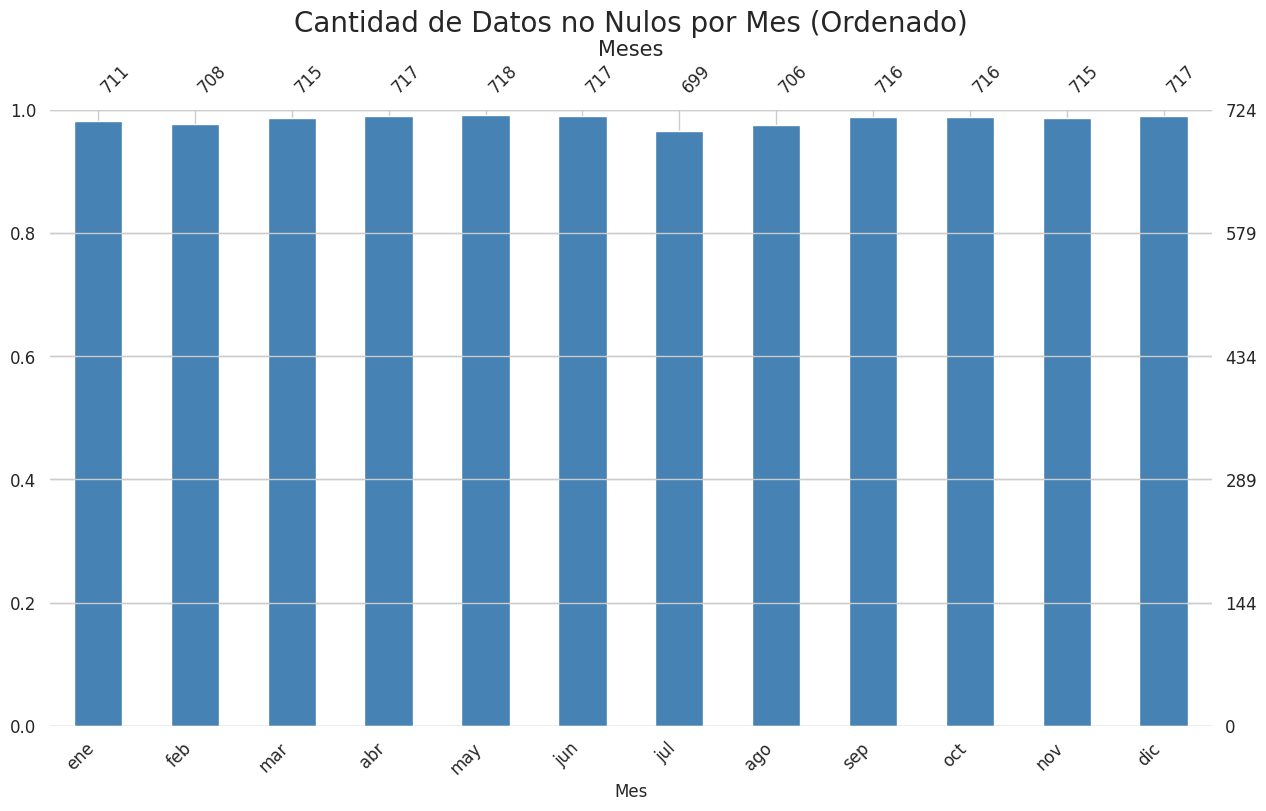

In [85]:
# Pivotear el DataFrame (los meses quedarán en orden alfabético)
df_pivoted = df_enriquecido.pivot_table(
    index=['Estación', 'Variable'],
    columns='Mes',
    values='Valor'
)

# Generar el gráfico con el DataFrame ya ordenado
msno.bar(df_pivoted, fontsize=12, figsize=(15, 8), color='steelblue')

# 5. Añadir título y mostrar el gráfico
plt.title('Cantidad de Datos no Nulos por Mes (Ordenado)', fontsize=20)
plt.xlabel('Meses', fontsize=15)
plt.ylabel('Observaciones no nulas', fontsize=15)
plt.show()


<Axes: >

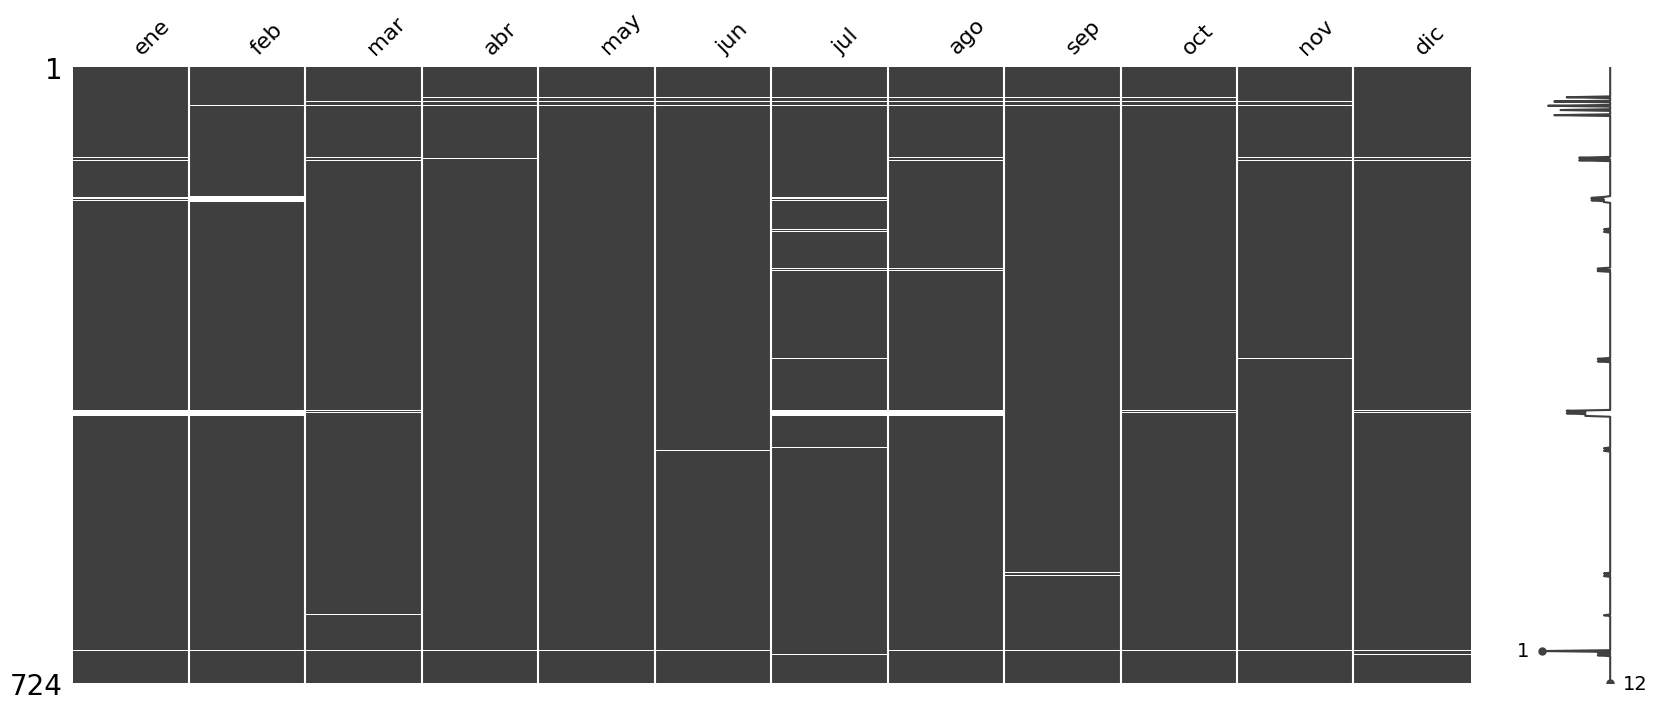

In [57]:
msno.matrix(df_pivoted, figsize=(20,8))

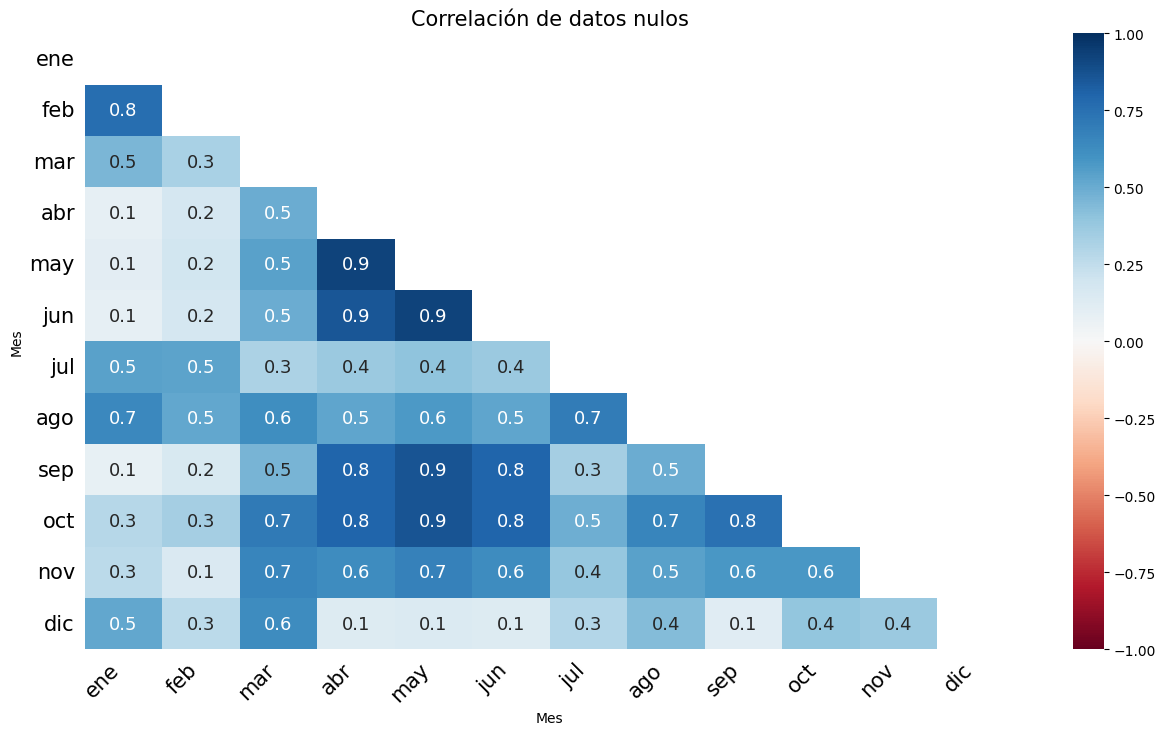

In [58]:
msno.heatmap(df_pivoted, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

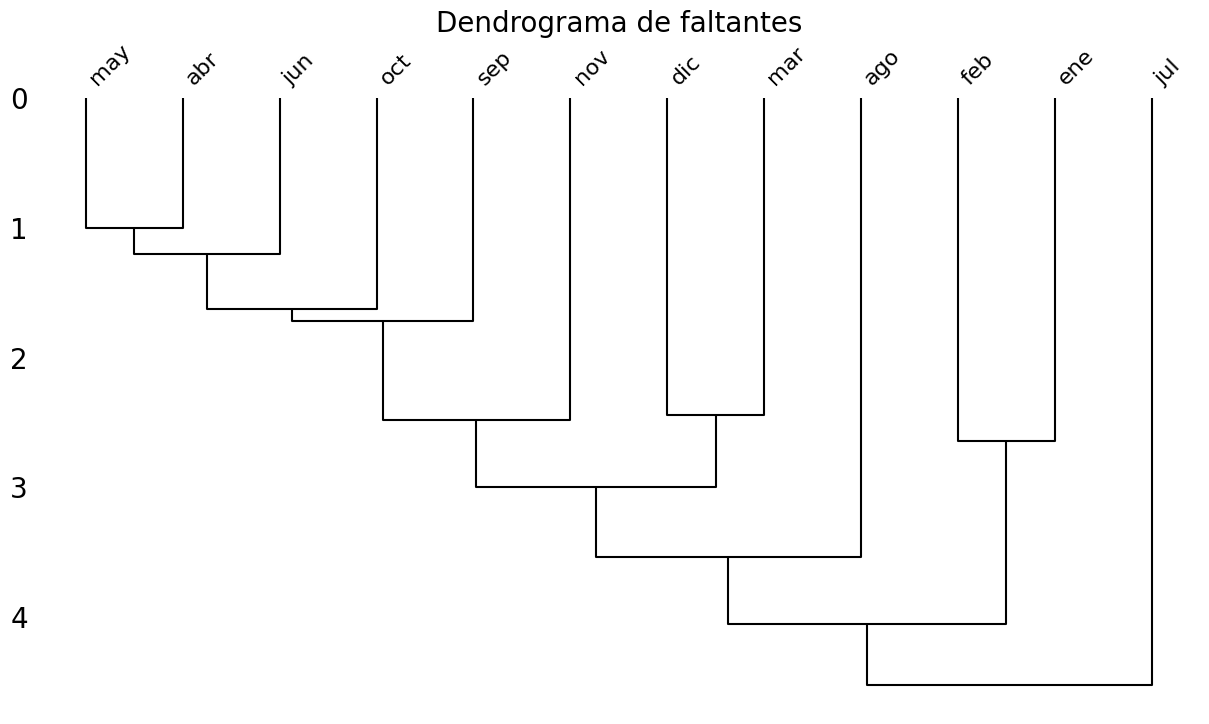

In [59]:
msno.dendrogram(df_pivoted, figsize=(15,8))
plt.title('Dendrograma de faltantes', fontsize=20)
plt.show()

In [60]:
print("Cantidad de datos duplicados:", df_pivoted.duplicated().sum())

Cantidad de datos duplicados: 5


--- Rangos (mínimo y máximo) por Variable ---
                                       min    max
Variable                                         
frecuencia_dias_precipitacion_gt_1mm   0.0   13.8
humedad_relativa_porcentaje           25.7   90.2
nubosidad_octavos                      1.3    7.5
precipitacion_mm                       0.0  277.9
temperatura_c                        -20.9   28.3
temperatura_maxima_c                 -17.5   35.5
temperatura_minima_c                 -25.0   22.5
velocidad_viento_kmh                   3.9   36.5


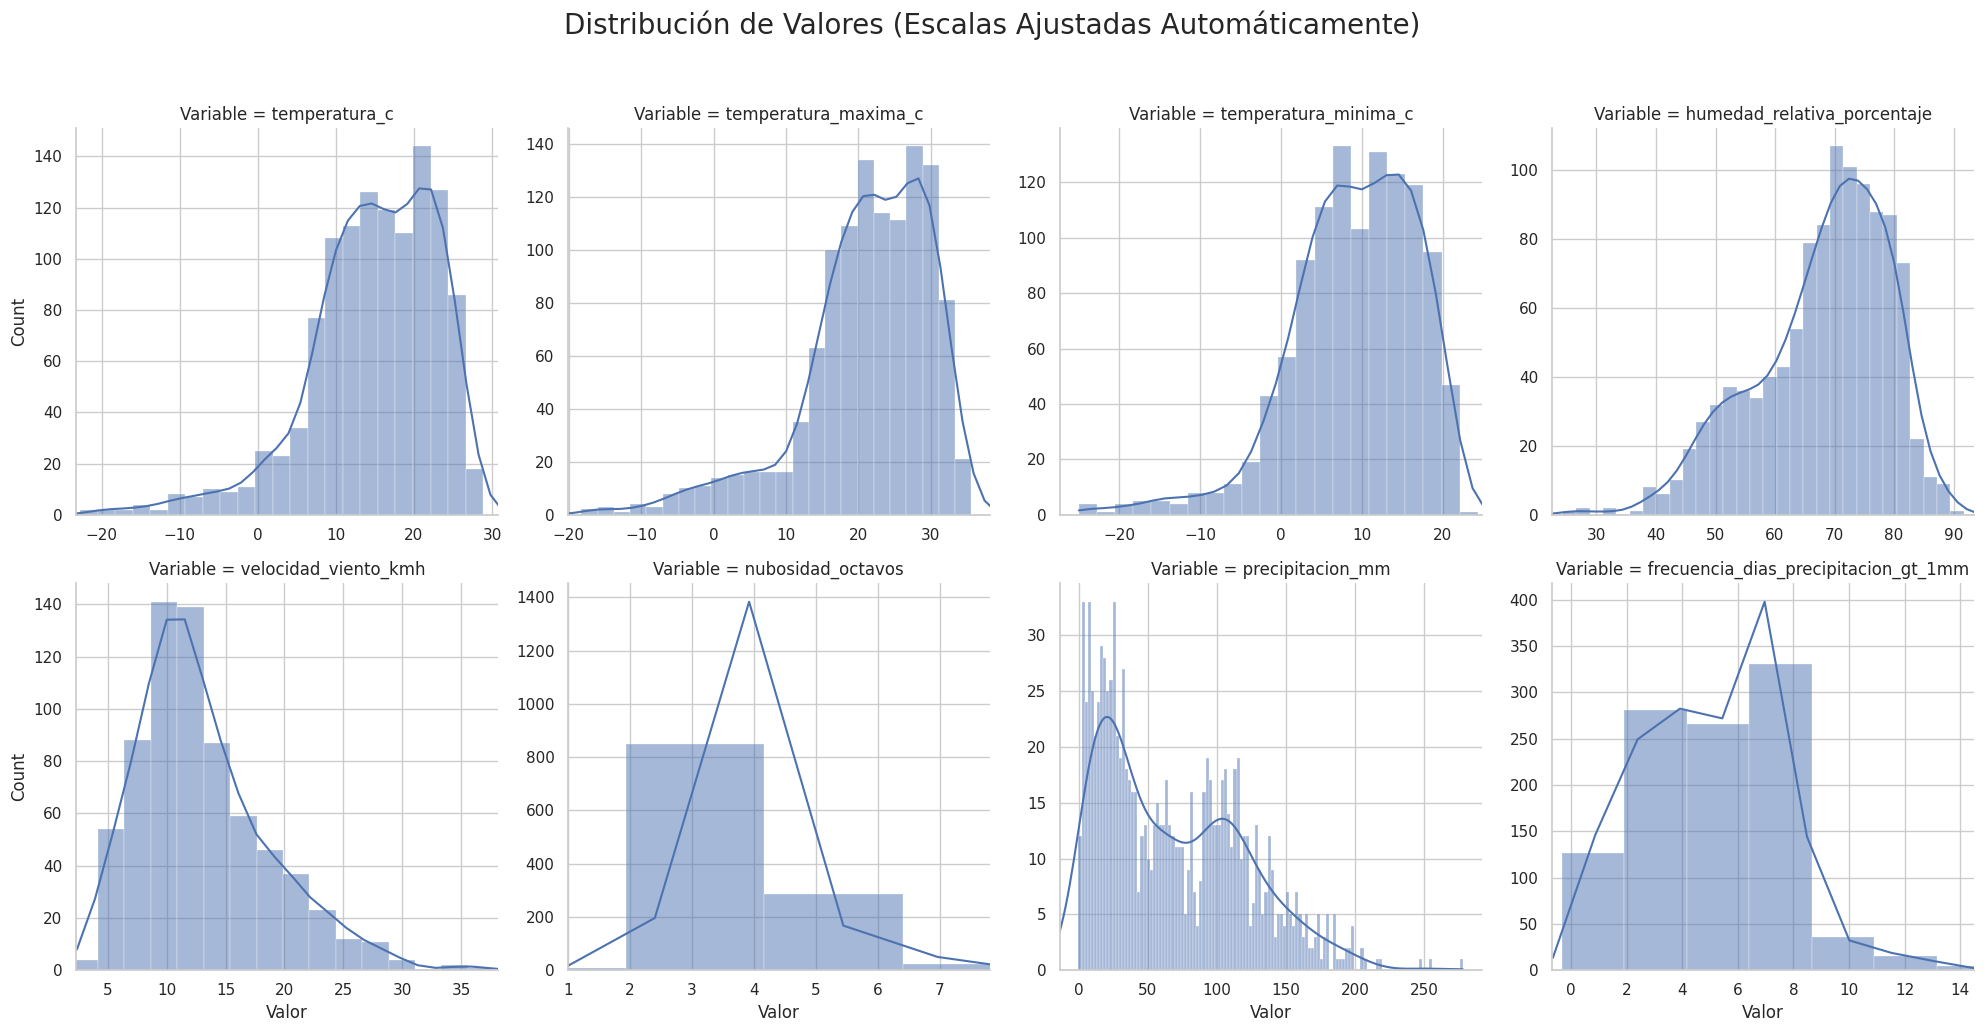

In [63]:
sns.set_theme(style="whitegrid")

# Agrupar por 'Variable' y agregar las funciones min y max para 'Valor'
rangos_por_variable = df_final.groupby('Variable')['Valor'].agg(['min', 'max'])

print("--- Rangos (mínimo y máximo) por Variable ---")
print(rangos_por_variable)
# --- Gráfico con ajuste automático de escala ---

# 1. Crear el gráfico de distribución como antes
g = sns.displot(
    data=df_final,
    x='Valor',
    col='Variable',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False}
)

# 2. Iterar sobre cada eje para personalizarlo dinámicamente
for ax in g.axes.flat:
    # Obtenemos el título del subplot (ej: "Variable = temperatura_c")
    titulo = ax.get_title()
    # Extraemos el nombre de la variable del título
    nombre_variable = titulo.split(' = ')[1]

    # Verificamos si la variable existe en nuestro DataFrame de rangos
    if nombre_variable in rangos_por_variable.index:
        # Obtenemos el min y max para esa variable
        min_val = rangos_por_variable.loc[nombre_variable, 'min']
        max_val = rangos_por_variable.loc[nombre_variable, 'max']

        # Calculamos un pequeño relleno (5% del rango total) para que el gráfico respire
        padding = (max_val - min_val) * 0.05

        # Aplicamos los nuevos límites al eje X
        ax.set_xlim(min_val - padding, max_val + padding)


# 3. Añadir un título principal y mostrar el gráfico
g.fig.suptitle('Distribución de Valores (Escalas Ajustadas Automáticamente)', y=1.03, fontsize=20)
g.fig.tight_layout()
plt.show()

--- Rangos de Temperatura por Provincia ---
                  min   max
provincia                  
ANTARTIDA       -20.9   2.2
BUENOS AIRES      6.1  24.6
CAPITAL FEDERAL  11.0  24.9
CATAMARCA        10.2  27.8
CHACO            14.8  26.9
CHUBUT            1.7  21.6
CORDOBA           8.1  25.4
CORRIENTES       13.1  26.9
ENTRE RIOS       10.7  25.6
FORMOSA          16.4  28.3
JUJUY             4.5  24.0
LA PAMPA          7.4  23.8
LA RIOJA          9.5  27.6
MENDOZA           3.8  25.9
MISIONES         14.9  27.2
NEUQUEN           6.0  24.1
RIO NEGRO         0.6  22.8
SALTA            10.1  26.4
SAN JUAN          7.2  27.3
SAN LUIS          7.0  24.8
SANTA CRUZ        0.6  16.4
SANTA FE          8.8  26.4
SANTIAGO DEL ES  12.1  27.0
TIERRA DEL FUEG   0.1  11.0
TUCUMAN          12.3  25.3


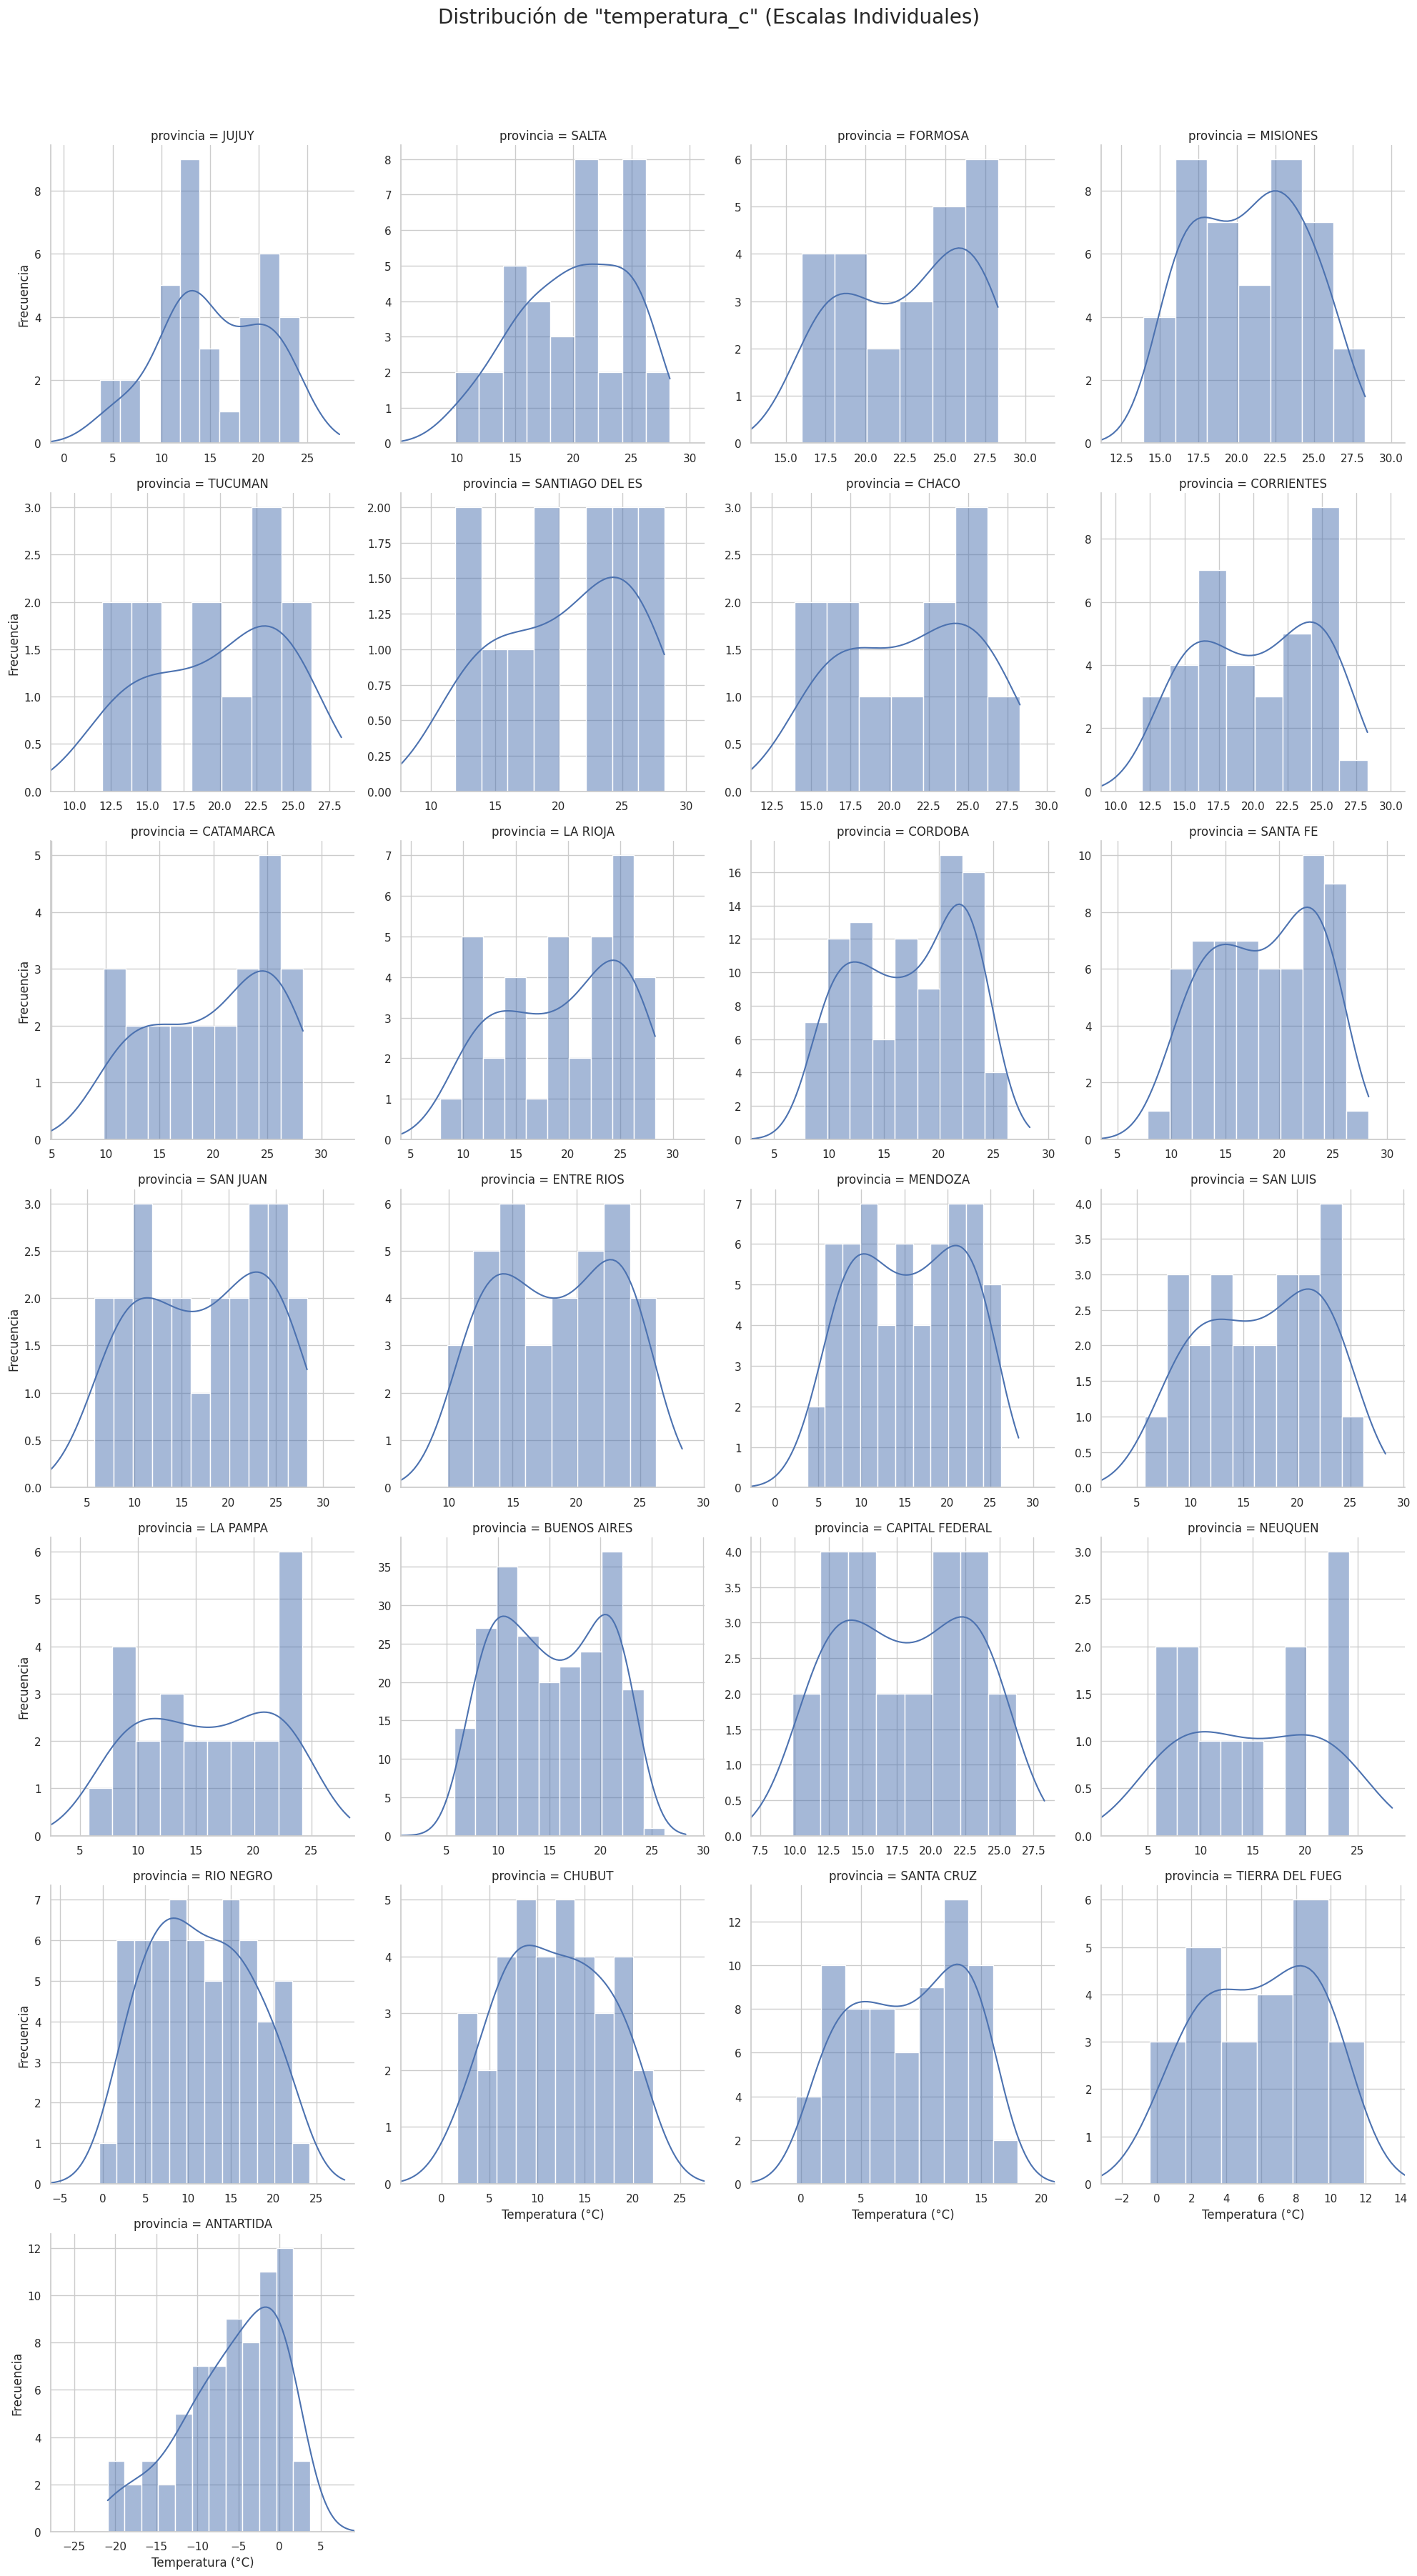

In [90]:
# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'temperatura_c'
df_filtrado = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada provincia
rangos_por_provincia = df_filtrado.groupby('provincia')['Valor'].agg(['min', 'max'])
print("--- Rangos de Temperatura por Provincia ---")
print(rangos_por_provincia)

# 3. Crear el gráfico de distribución con ejes NO compartidos
g = sns.displot(
    data=df_filtrado,
    x='Valor',
    col='provincia',
    col_wrap=4,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    # Extraemos el nombre de la provincia del título (ej: "provincia = JUJUY")
    nombre_provincia = titulo.split(' = ')[1]

    if nombre_provincia in rangos_por_provincia.index:
        min_val = rangos_por_provincia.loc[nombre_provincia, 'min']
        max_val = rangos_por_provincia.loc[nombre_provincia, 'max']
        
        # Añadimos un pequeño relleno (padding) para que el gráfico no se vea apretado
        padding = (max_val - min_val) * 0.30
        
        # Aplicamos los límites específicos de la provincia
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" (Escalas Individuales)', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (°C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

--- Rangos de Temperatura por Región ---
            min   max
region               
Antártida -20.9   2.2
Cuyo        3.8  25.9
NEA        13.1  28.3
NOA         4.5  27.8
Pampeana    8.1  25.4
Patagonia   1.7  24.1


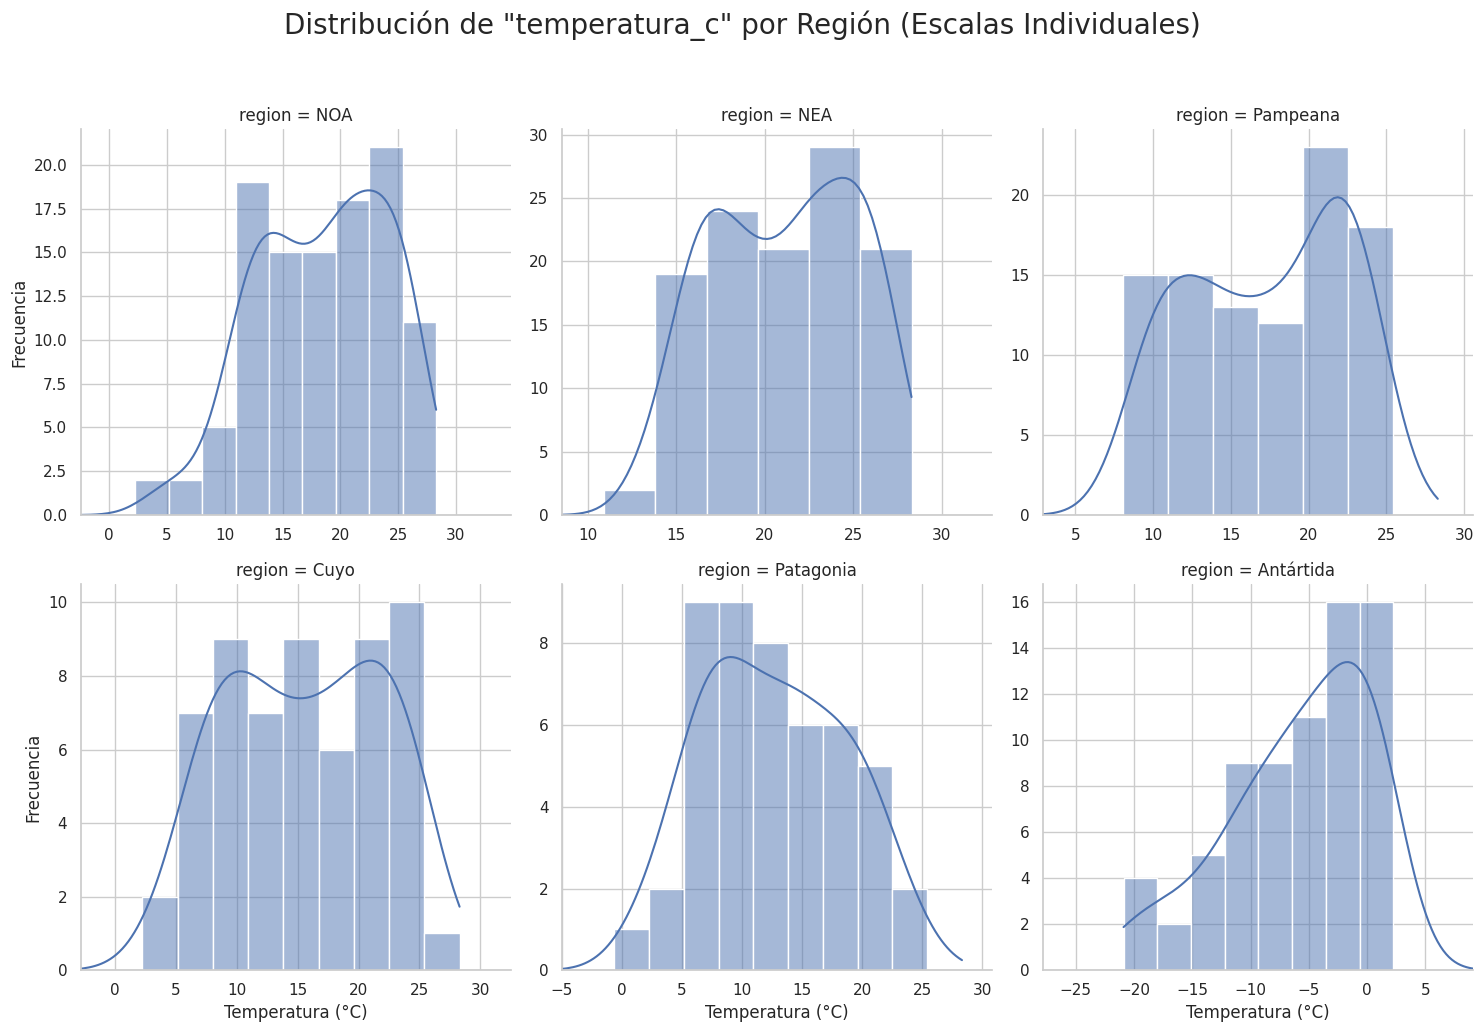

In [100]:
# Se asume que tu DataFrame 'df_enriquecido' con la columna 'region' ya existe.

# 1. Filtrar para una sola variable de interés
variable_a_analizar = 'temperatura_c'
df_filtrado_region = df_enriquecido[df_enriquecido['Variable'] == variable_a_analizar].copy()

# 2. Calcular los rangos (mínimo y máximo) para cada región
rangos_por_region = df_filtrado_region.groupby('region')['Valor'].agg(['min', 'max'])
print("--- Rangos de Temperatura por Región ---")
print(rangos_por_region)

# 3. Crear el gráfico de distribución con ejes independientes
g = sns.displot(
    data=df_filtrado_region,
    x='Valor',
    col='region',
    col_wrap=3,
    kind='hist',
    kde=True,
    facet_kws={'sharey': False, 'sharex': False} # Ejes X independientes
)

# 4. Iterar sobre cada eje para ajustar la escala dinámicamente
for ax in g.axes.flat:
    titulo = ax.get_title()
    # Extraemos el nombre de la región del título (ej: "region = NOA")
    nombre_region = titulo.split(' = ')[1]

    if nombre_region in rangos_por_region.index:
        min_val = rangos_por_region.loc[nombre_region, 'min']
        max_val = rangos_por_region.loc[nombre_region, 'max']
        
        # Añadimos un relleno (padding) del 5% del rango total para que el gráfico respire
        padding = (max_val - min_val) * 0.3
        
        # Aplicamos los límites específicos de la región
        ax.set_xlim(min_val - padding, max_val + padding)

# 5. Ajustar títulos y mostrar
g.fig.suptitle(f'Distribución de "{variable_a_analizar}" por Región (Escalas Individuales)', y=1.03, fontsize=20)
g.set_axis_labels("Temperatura (°C)", "Frecuencia")
g.fig.tight_layout()
plt.show()

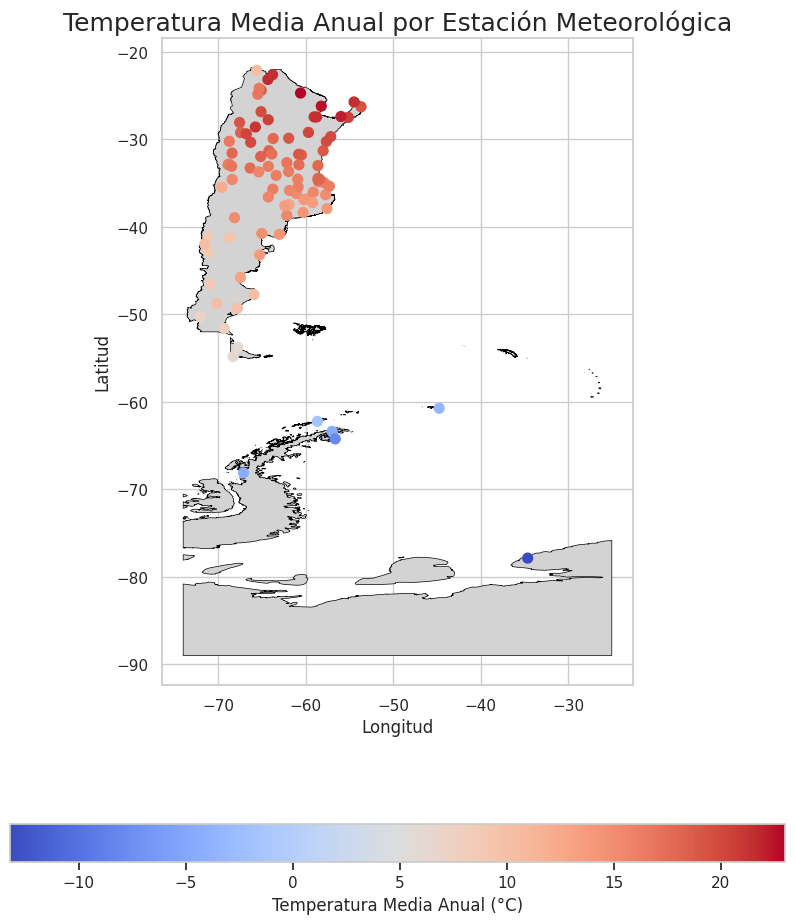

In [116]:

gdf_estaciones = geopandas.GeoDataFrame(
    df_bases, 
    geometry=geopandas.points_from_xy(df_bases.longitud, df_bases.latitud),
    crs="EPSG:4326"
)

# --- 2. Preparar los Datos a Visualizar ---
df_temperatura_media = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('Estación')['Valor'].mean().reset_index()
df_temperatura_media.rename(columns={'Valor': 'temp_media_anual'}, inplace=True)
# --- 3. Unir Datos (sin cambios) ---
gdf_final_para_mapa = pd.merge(
    gdf_estaciones,
    df_temperatura_media,
    on='Estación',
    how='inner'
)

# --- 4. Dibujar el Mapa (Usando el archivo local) ---

# Reemplazá 'ruta/a/tu/archivo.shp' con la ruta al archivo que descargaste
# Por ejemplo: 'datos/provincias.shp'
ruta_al_mapa = "datos/pais/paisPolygon.shp"  # <-- CAMBIÁ ESTA RUTA
argentina_mapa = geopandas.read_file(ruta_al_mapa)


# Creamos la figura y el eje del gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Dibujamos el mapa de provincias como base
argentina_mapa.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Superponemos los puntos de las estaciones
gdf_final_para_mapa.plot(
    column='temp_media_anual', 
    ax=ax, 
    legend=True,
    cmap='coolwarm',
    markersize=50,
    legend_kwds={'label': "Temperatura Media Anual (°C)", 'orientation': "horizontal"}
)

# Configuramos el título y los ejes
ax.set_title('Temperatura Media Anual por Estación Meteorológica', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()

Provincias en el archivo del mapa: ['ciudad autónoma de buenos aires' 'san luis' 'santa fe' 'tucumán'
 'mendoza' 'jujuy' 'santiago del estero' 'córdoba' 'la pampa' 'chaco'
 'formosa' 'santa cruz' 'chubut' 'san juan' 'río negro' 'misiones'
 'neuquén' 'la rioja' 'catamarca' 'salta' 'buenos aires'
 'tierra del fuego, antártida e islas del atlántico sur' 'entre ríos'
 'corrientes']
Provincias en los datos climáticos: ['ANTARTIDA' 'BUENOS AIRES' 'CAPITAL FEDERAL' 'CATAMARCA' 'CHACO' 'CHUBUT'
 'CORDOBA' 'CORRIENTES' 'ENTRE RIOS' 'FORMOSA' 'JUJUY' 'LA PAMPA'
 'LA RIOJA' 'MENDOZA' 'MISIONES' 'NEUQUEN' 'RIO NEGRO' 'SALTA' 'SAN JUAN'
 'SAN LUIS' 'SANTA CRUZ' 'SANTA FE' 'SANTIAGO DEL ES' 'TIERRA DEL FUEG'
 'TUCUMAN']


KeyError: 'temp_media_provincial'

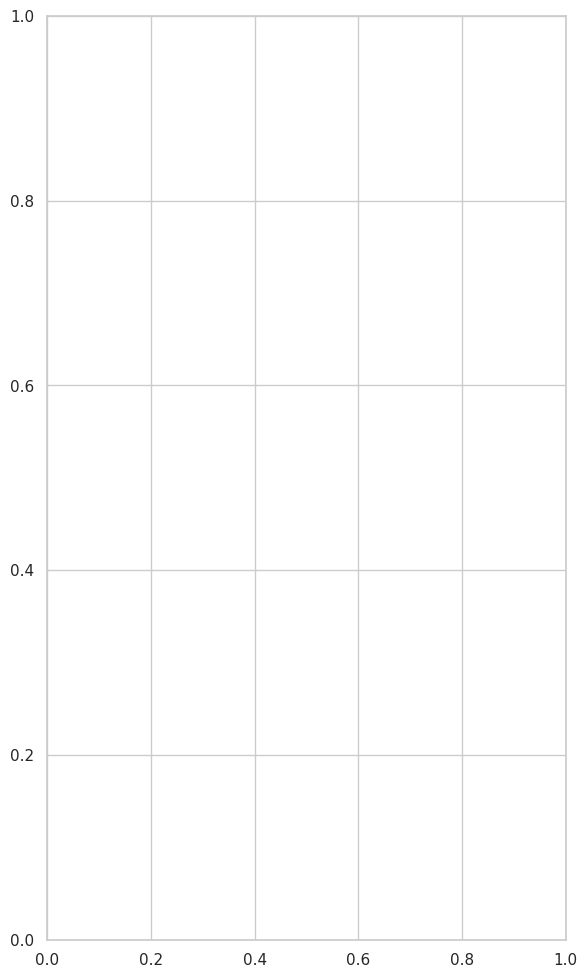

In [ ]:
# a) Calcular la temperatura media por provincia
df_temp_provincia = df_enriquecido[df_enriquecido['Variable'] == 'temperatura_c'].groupby('provincia')['Valor'].mean().reset_index()

# b) Renombrar la columna 'Valor' a su nombre final
df_temp_provincia.rename(columns={'Valor': 'temp_media_provincial'}, inplace=True)

# c) Limpiar los nombres de las provincias para la unión
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia'].apply(limpiar_texto)

# d) Corregir nombres específicos (abreviaturas, etc.)
mapa_correcciones = {
    'tierra_del_fueg': 'tierra_del_fuego_antartida_e_islas_del_atlantico_sur',
    'santiago_del_es': 'santiago_del_estero',
    'capital_federal': 'ciudad_autonoma_de_buenos_aires'
}
df_temp_provincia['provincia_limpia'] = df_temp_provincia['provincia_limpia'].replace(mapa_correcciones)


# --- 2. PREPARAR DATOS DEL MAPA ---

ruta_mapa_provincias = "datos/provincia/provinciaPolygon.shp"
mapa_provincias = geopandas.read_file(ruta_mapa_provincias)

# Limpiar los nombres de las provincias en el mapa para que coincidan
# ¡IMPORTANTE! Asegurate que la columna 'nam' exista en tu shapefile. Si no, usa el nombre correcto.
mapa_provincias['provincia_limpia'] = mapa_provincias['nam'].apply(limpiar_texto)


# --- 3. UNIR LOS DATAFRAMES ---

# Unimos usando la columna 'provincia_limpia' que ahora existe en ambos DataFrames
mapa_final = pd.merge(
    mapa_provincias,
    df_temp_provincia,
    on='provincia_limpia',
    how='left'
)


# --- 4. DIBUJAR EL MAPA ---

# Agregamos una verificación final para estar seguros
print("Columnas disponibles en el mapa final:", mapa_final.columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# El código de ploteo ahora funcionará porque la columna sí existe
mapa_final.plot(
    column='temp_media_provincial',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Sin datos",
    },
    legend_kwds={'label': "Temperatura Media Provincial (°C)", 'orientation': "horizontal"}
)

ax.set_title('Temperatura Media por Provincia', fontsize=18)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_aspect('equal')
plt.show()